In [71]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

In [72]:
def MC_estimator_h2(pi, X, a, sigma, sample_size):
    '''
    Estimate for E[\pi(X0)] where X0 = (sigma*Z + X)/a and Z starndar normal 
    Parameter:
        pi (funtion): (M,N) -> (M,)
        X  (array):   (N,)
        a  (Float)
        sigma (Float)
        Sample_size (int)

    return:
        float
    '''
    dim_X = X.shape[0]
    Z = np.random.randn(sample_size, dim_X)
    X0 = (sigma * Z + X)/a
    # Aplicar pi em X0
    pi_X0 = pi(X0)
    MC = np.mean(pi_X0)
    return MC

def MC_estimator_h1(pi, X, a, sigma, sample_size):
    '''
    Estimate for E[Z \pi(X0)/(sigma)] where X0 = (sigma*Z + X)/a and Z starndar normal 

    Parameter:
        pi (funtion): (M,N) -> (M,)
        X  (array):   (N,)
        a  (Float)
        sigma (Float)
        Sample_size (int)

    return:
        array:  (N,)
    '''
    dim_X = X.shape[0]
    Z = np.random.randn(sample_size, dim_X) 
    X0 = (sigma * Z + X)/a
    # Aplicar pi em X0
    pi_X0 = pi(X0)
    M = pi_X0.shape[0]
    pi_X0 = pi_X0.reshape(M,1)
    expression = (Z * pi_X0) / sigma
    MC = np.mean(expression, axis = 0)
    return MC

def beta_funtion(t, bmin = 1.0, bmax = 1.0):
    return bmin + (bmax - bmin)*t

def beta_funtion_integral(t, bmin = 1.0, bmax = 1.0):
    return bmin*t + (bmax - bmin)*(t**2)/2

def compute_a(t, bmin = 1.0, bmax = 1.0):
    beta_integral = beta_funtion_integral(t, bmin = bmin, bmax = bmax)
    return np.exp(- 0.5 * beta_integral) + 1e-5

def compute_sigma(t, bmin = 1.0, bmax = 1.0):
    beta_integral = beta_funtion_integral(t, bmin = bmin, bmax = bmax)
    return np.sqrt(1 - np.exp( - beta_integral)) + 1e-5

def MC_estimator_score(t, X, pi, sample_size, bmin = 1.0, bmax = 1.0, debug = False):
    a = compute_a(t, bmin = bmin, bmax = bmax)
    sigma = compute_sigma(t, bmin = bmin, bmax = bmax)
    h1 = MC_estimator_h1(pi, X, a, sigma, sample_size)
    h2 = MC_estimator_h2(pi, X, a, sigma, sample_size)
    if debug:
        print('a', a)
        print('sigma', sigma)
        print('h1', h1)
        print('h2', h2)
    MC = h1/h2
    return MC

def compute_exact_score_normal(t, X, mu = 0, var = 1, bmin = 1.0, bmax = 1.0):
    beta_integral = beta_funtion_integral(t, bmin = bmin, bmax = bmax)
    mut = np.exp(- 0.5 * beta_integral)*mu
    vart = 1  + (var - 1)*np.exp( - beta_integral)
    return -(X - mut)/vart

def sample(pi, dim, bmin = 1.0, bmax = 1.0, T = 3, N = 1000, sample_size = 30, debug = False):
    X = np.random.normal(size = (dim))
    dt = T/N
    for i in range(0, N):
        if debug:
            print(i)
        t = dt * i
        score = MC_estimator_score(T - t, X, pi, sample_size, bmin = bmin, bmax = bmax, debug = debug)
        #score = compute_exact_score_normal(t, X)
        if debug:
            print('score', score)
            print('X', X)
        beta = beta_funtion(T - t, bmin = bmin, bmax = bmax)
        drift = beta * X / 2 + beta * score
        vol = np.sqrt(beta)
        dW =  np.sqrt(dt)*np.random.normal(size = (dim)) 
        X = X + drift*dt + vol*dW
    return X 

In [73]:
def multivariate_gaussian_density(X, mean, cov):
    """
    Applies the multivariate Gaussian density to each row of X.
    
    Parameters:
        X (numpy.ndarray): Array of shape (N, M), where N is the number of points and M is the dimensionality.
        mean (numpy.ndarray): Mean vector of shape (M,).
        cov (numpy.ndarray): Covariance matrix of shape (M, M).
    
    Returns:
        numpy.ndarray: Array of densities of shape (N,).
    """
    # Number of dimensions
    M = X.shape[1]
    
    # Covariance matrix determinant and inverse
    cov_inv = np.linalg.inv(cov)
    # cov_det = np.linalg.det(cov)
    
    # Normalizing constant
    # norm_const = 1 / np.sqrt((2 * np.pi) ** M * cov_det)
    
    # Compute the density for each row in X
    diff = X - mean
    exponent = -0.5 * np.sum(diff @ cov_inv * diff, axis=1)
    densities = np.exp(exponent) # * norm_const
    
    return densities


In [74]:
def pi_normal(X):
    mu = np.array([0])
    cov = np.array([[1]])
    return multivariate_gaussian_density(X, mu, cov)

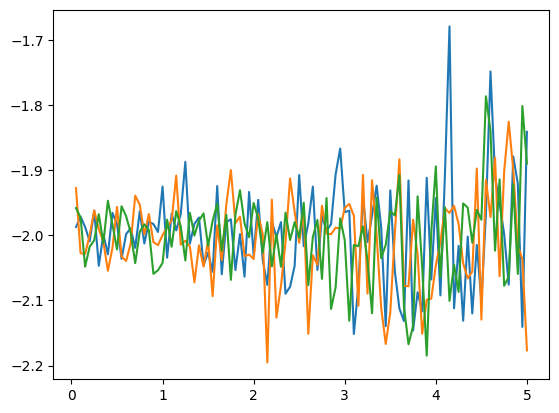

In [77]:
T = 5
N = 100
X = X = np.array([2])
times = [i*T/N for i in range(1, N+1)]
score1 = [MC_estimator_score(t, X, pi_normal, sample_size=2**15) for t in times]
score2 = [MC_estimator_score(t, X, pi_normal, sample_size=2**15) for t in times]
score3 = [MC_estimator_score(t, X, pi_normal, sample_size=2**15) for t in times]
plt.plot(times, score1)
plt.plot(times, score2)
plt.plot(times, score3)

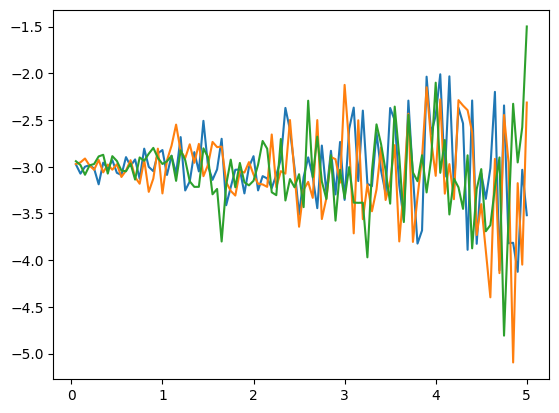

In [167]:
T = 5
N = 100
X = X = np.array([3])
times = [i*T/N for i in range(1, N+1)]
score1 = [MC_estimator_score(t, X, pi_normal, sample_size=2**15) for t in times]
score2 = [MC_estimator_score(t, X, pi_normal, sample_size=2**15) for t in times]
score3 = [MC_estimator_score(t, X, pi_normal, sample_size=2**15) for t in times]
plt.plot(times, score1)
plt.plot(times, score2)
plt.plot(times, score3)

In [166]:
sample(pi_normal, 1, T = 2, sample_size=2**15)

array([0.89770105])

In [170]:
model_sample = [sample(pi_normal, 1, T = 2, sample_size=2**10)[0] for _ in range(1000)]

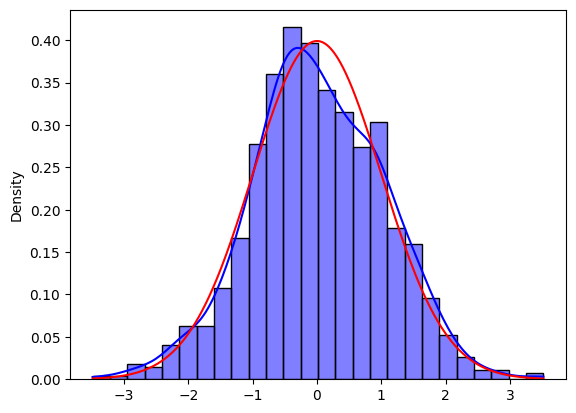

In [172]:
data = np.array(model_sample)

x = np.linspace(min(data), max(data), 1000)
y = norm.pdf(x, 0, 1)
sns.histplot(data, kde=True, stat="density", color="blue", label="Dados Empíricos")
plt.plot(x, y, color="red", label="Densidade Normal")


In [173]:
def pi_normal(X):
    mu = np.array([1])
    cov = np.array([[1]])
    return multivariate_gaussian_density(X, mu, cov)

In [177]:
model_sample = [sample(pi_normal, 1, T = 3, sample_size=2**10)[0] for _ in range(1000)]

C:\Users\henri\AppData\Local\Temp\ipykernel_10284\1004037353.py:73: RuntimeWarning: invalid value encountered in divide
  MC = h1/h2


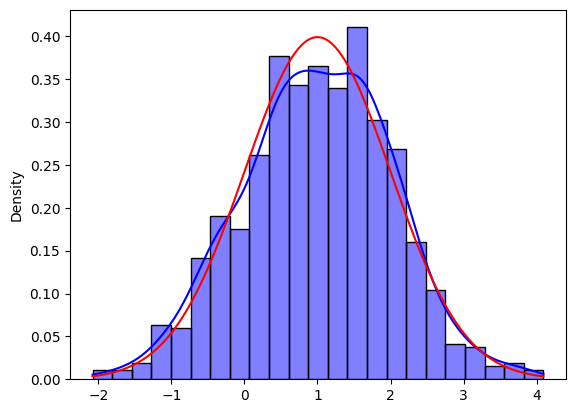

In [178]:
data = np.array(model_sample)
x = np.linspace(min(data), max(data), 1000)
y = norm.pdf(x, 1, 1)
sns.histplot(data, kde=True, stat="density", color="blue", label="Dados Empíricos")
plt.plot(x, y, color="red", label="Densidade Normal")


In [3]:
def pi_normal(X):
    mu = np.array([2])
    cov = np.array([[0.3]])
    return multivariate_gaussian_density(X, mu, cov)

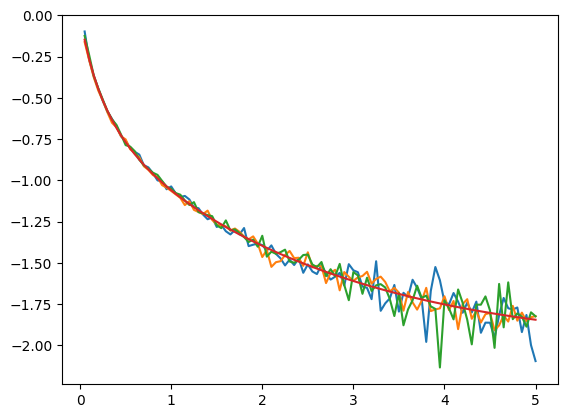

In [ ]:
T = 5
N = 100
X = np.array([2])
times = [i*T/N for i in range(1, N+1)]
score1 = [MC_estimator_score(t, X, pi_normal, sample_size=2**15) for t in times]
score2 = [MC_estimator_score(t, X, pi_normal, sample_size=2**15) for t in times]
score3 = [MC_estimator_score(t, X, pi_normal, sample_size=2**15) for t in times]
score_exato = [compute_exact_score_normal(t, X, mu = 2, var = 0.3) for t in times]
plt.plot(times, score1)
plt.plot(times, score2)
plt.plot(times, score3)
plt.plot(times, score_exato)

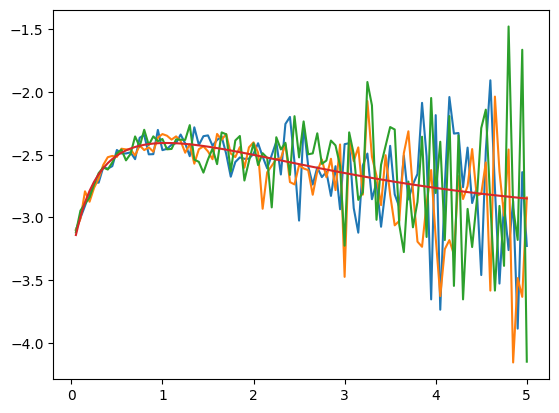

In [6]:
T = 5
N = 100
X = np.array([3])
times = [i*T/N for i in range(1, N+1)]
score1 = [MC_estimator_score(t, X, pi_normal, sample_size=2**15) for t in times]
score2 = [MC_estimator_score(t, X, pi_normal, sample_size=2**15) for t in times]
score3 = [MC_estimator_score(t, X, pi_normal, sample_size=2**15) for t in times]
score_exato = [compute_exact_score_normal(t, X, mu = 2, var = 0.3) for t in times]
plt.plot(times, score1)
plt.plot(times, score2)
plt.plot(times, score3)
plt.plot(times, score_exato)

In [7]:
model_sample = [sample(pi_normal, 1, T = 3, sample_size=2**10)[0] for _ in range(1000)]

C:\Users\henri\AppData\Local\Temp\ipykernel_18008\1004037353.py:73: RuntimeWarning: invalid value encountered in divide
  MC = h1/h2


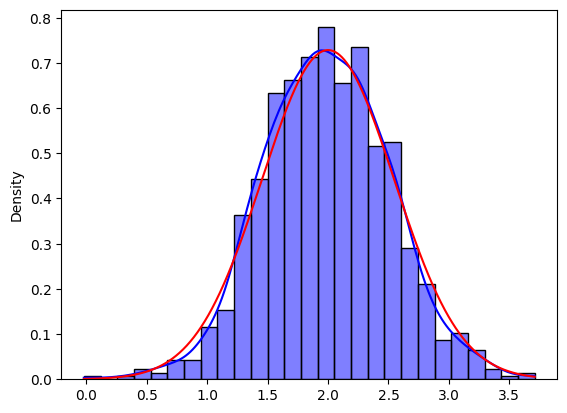

In [13]:
data = np.array(model_sample)

x = np.linspace(min(data), max(data), 1000)
y = norm.pdf(x, 2, np.sqrt(0.3))
sns.histplot(data, kde=True, stat="density", color="blue", label="Dados Empíricos")
plt.plot(x, y, color="red", label="Densidade Normal")


In [14]:
def cauchy_distribution(X):
    out = 1 / (1 + X[:, 0]**2)
    return out

In [15]:
model_sample = [sample(cauchy_distribution, 1, T = 3, sample_size=2**10)[0] for _ in range(1000)]

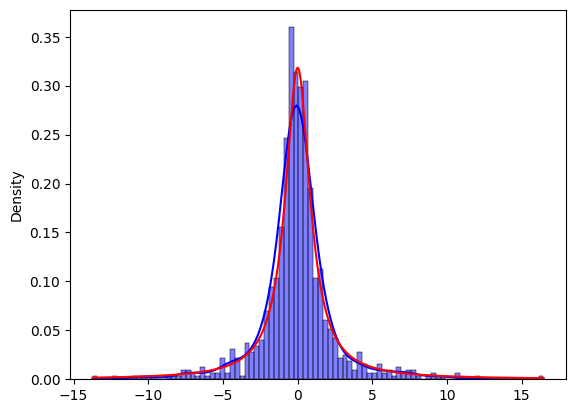

In [16]:
from scipy.stats import cauchy
data = np.array(model_sample)
x = np.linspace(min(data), max(data), 1000)
y = cauchy.pdf(x, loc=0, scale=1) 
sns.histplot(data, kde=True, stat="density", color="blue", label="Dados Empíricos")
plt.plot(x, y, color="red", label="Densidade Normal")

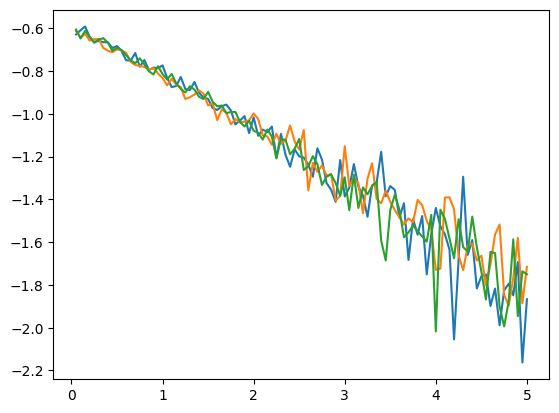

In [18]:
T = 5
N = 100
X = np.array([3])
times = [i*T/N for i in range(1, N+1)]
score1 = [MC_estimator_score(t, X, cauchy_distribution, sample_size=2**15) for t in times]
score2 = [MC_estimator_score(t, X, cauchy_distribution, sample_size=2**15) for t in times]
score3 = [MC_estimator_score(t, X, cauchy_distribution, sample_size=2**15) for t in times]
plt.plot(times, score1)
plt.plot(times, score2)
plt.plot(times, score3)

In [35]:
def gausssian_mixture(X):
    mu1 = np.array([[2]])
    mu2 = np.array([[-3]])
    var = 0.3
    componet1 = np.exp(-((X - mu1)**2).sum(axis = 1) / (2*var))
    componet2 = np.exp(-((X - mu2)**2).sum(axis = 1) / (2*var))
    return componet1 + componet2

In [39]:
model_sample = [sample(gausssian_mixture, 1, T = 5, sample_size=2**8, N=3000)[0] for _ in range(1000)]

C:\Users\henri\AppData\Local\Temp\ipykernel_18008\1004037353.py:73: RuntimeWarning: invalid value encountered in divide
  MC = h1/h2
C:\Users\henri\AppData\Local\Temp\ipykernel_18008\1004037353.py:73: RuntimeWarning: divide by zero encountered in divide
  MC = h1/h2


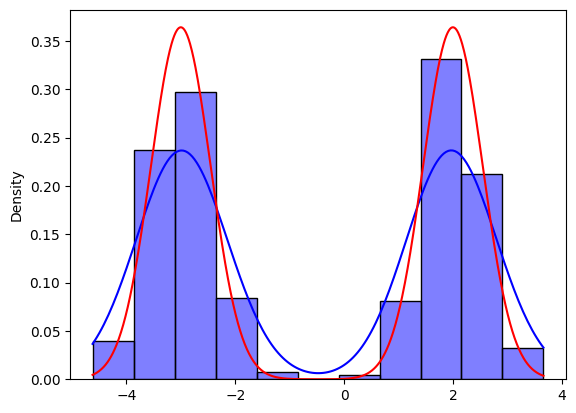

In [38]:
y1 = norm.pdf(x, 2, np.sqrt(0.3))
y2 = norm.pdf(x, -3, np.sqrt(0.3))
y = 0.5 * y1 + 0.5 * y2
data = np.array(model_sample)
x = np.linspace(min(data), max(data), 1000)
y1 = norm.pdf(x, 2, np.sqrt(0.3))
y2 = norm.pdf(x, -3, np.sqrt(0.3))
y = 0.5 * y1 + 0.5 * y2
sns.histplot(data, kde=True, stat="density", color="blue", label="Dados Empíricos")
plt.plot(x, y, color="red", label="Densidade Normal")

In [41]:
def gausssian_mixture_multi(X):
    mu1 = np.array([[2,2]])
    mu2 = np.array([[-2,-2]])
    var = 0.3

    componet1 = np.exp(-((X - mu1)**2).sum(axis = 1) / (2*var))
    componet2 = np.exp(-((X - mu2)**2).sum(axis = 1) / (2*var))
    return componet1 + componet2

In [45]:
model_sample = [sample(gausssian_mixture_multi, 2, T = 3, sample_size=2**7, N = 500) for _ in range(1000)]

C:\Users\henri\AppData\Local\Temp\ipykernel_18008\1004037353.py:73: RuntimeWarning: invalid value encountered in divide
  MC = h1/h2


<Axes: >

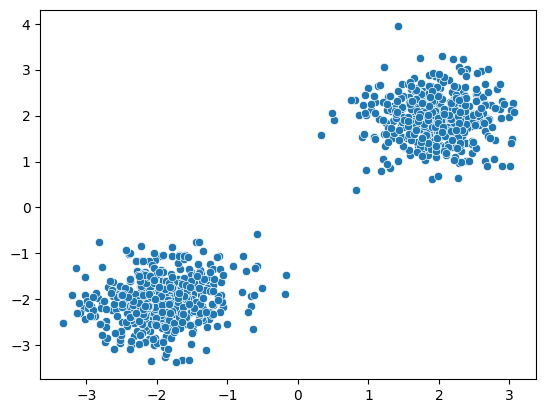

In [50]:
sns.scatterplot(x = np.array(model_sample)[:, 0], y = np.array(model_sample)[:,1])

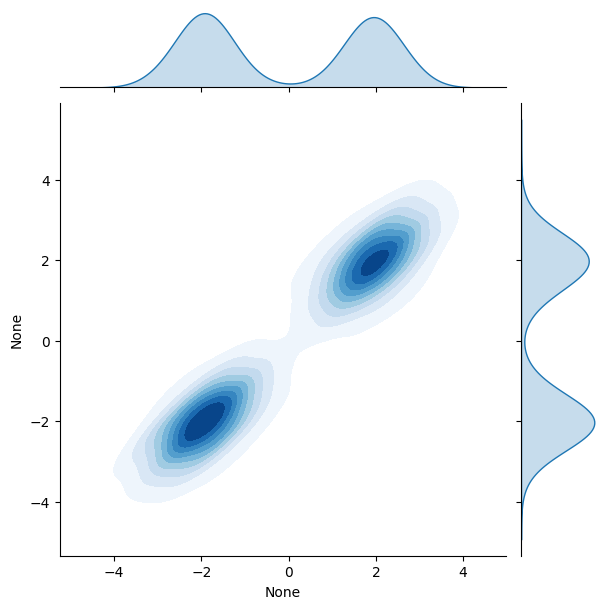

In [55]:
data = np.array(model_sample)
sns.jointplot(x = np.array(model_sample)[:, 0], y = np.array(model_sample)[:,1], cmap="Blues", fill=True, kind='kde')
plt.show()

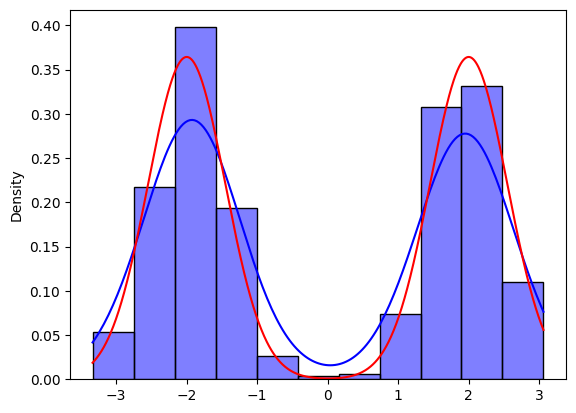

In [68]:
data1 = np.array(model_sample)[:, 0]
data1 = data1[~np.isnan(data1)]
x = np.linspace(min(data1), max(data1), 1000)
y1 = norm.pdf(x, 2, np.sqrt(0.3))
y2 = norm.pdf(x, -2, np.sqrt(0.3))
y = 0.5 * y1 + 0.5 * y2
sns.histplot(data1, kde=True, stat="density", color="blue", label="Dados Empíricos")
plt.plot(x, y, color="red", label="Densidade Normal")

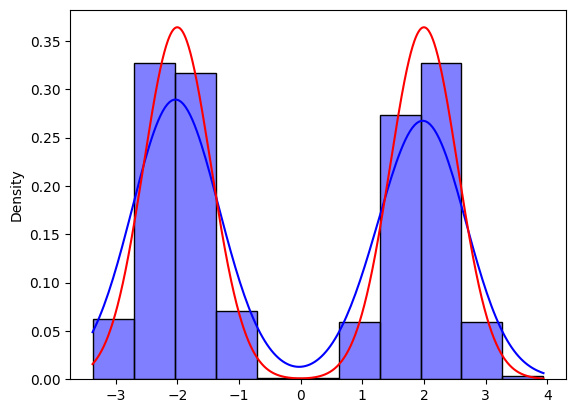

In [69]:
data2 = np.array(model_sample)[:, 1]
data2 = data2[~np.isnan(data2)]
x = np.linspace(min(data2), max(data2), 1000)
y1 = norm.pdf(x, 2, np.sqrt(0.3))
y2 = norm.pdf(x, -2, np.sqrt(0.3))
y = 0.5 * y1 + 0.5 * y2
sns.histplot(data2, kde=True, stat="density", color="blue", label="Dados Empíricos")
plt.plot(x, y, color="red", label="Densidade Normal")